In [3]:
import torch
import sys
import os
# # add parent directory to path
# sys.path.append(os.path.dirname(os.path.abspath(__file__)))
# # add sibling directory to path 
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))# def 

sys.path.append('/home/afahim2/tmp/clip-project/clipverse')
# sys.path.append('/home/afahim2/tmp/babylm/baby_lm_2024/git-2024')


from clips.clip_assembler import ClipAssembler
from src.evaluator import Evaluator
from dataset_processors.mscoco_processor import MSCOCOProcessor

from src.prepare_config import prepare_config
from clips.hf_clip import HFClipOutput, HFClip
import torch.nn.functional as F
import numpy as np
import pandas as pd
import clip
from torchvision import datasets
import random
from tqdm import tqdm
from pathlib import Path

/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import importlib
importlib.reload(sys.modules['src'].prepare_config)

<module 'src.prepare_config' from '/home/afahim2/tmp/clip-project/clipverse/src/prepare_config.py'>

In [5]:
cuda_device = 'cuda:0'
ROOT = '/home/afahim2/tmp/clip-project/clipverse'

In [6]:
mscoco_paths = {
        # 128D

        # Seed 42
        'mscoco_default_128d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_42_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_EVAL.pt',
        'mscoco_cua_128d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_42_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL3.pt',
        'mscoco_cuaxu_128d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_42_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_EVAL.pt',

        # Seed 24

        'mscoco_default_128d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_24_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cua_128d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_24_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cuaxu_128d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_24_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',

        # Seed = 44
        'mscoco_default_128d_s44':  '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_44_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cua_128d_s44':  '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_44_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cuaxu_128d_s44': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_44_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',

        # 64D

        'mscoco_default_64d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_42_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_EVAL.pt',
        'mscoco_cua_64d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_42_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_FINAL3.pt',
        'mscoco_cuaxu_64d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_42_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_EVAL.pt',

        'mscoco_default_64d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_24_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cua_64d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_24_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cuaxu_64d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_24_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',

        'mscoco_default_64d_s44': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_44_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cua_64d_s44': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_44_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cuaxu_64d_s44': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_44_finetune_I1C2E1E2_64_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',

        # 32D

        'mscoco_default_32d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_42_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_EVAL.pt',
        'mscoco_cua_32d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_42_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_FINAL3.pt',
        'mscoco_cuaxu_32d_s42': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_42_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_EVAL.pt',

        'mscoco_default_32d_s24':  '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_24_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cua_32d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_24_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cuaxu_32d_s24': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_24_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',

        'mscoco_default_32d_s44': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lit_44_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cua_32d_s44': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_44_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
        'mscoco_cuaxu_32d_s44': '/remote/cirrus-home/afahim2/tmp/clip-project/clipverse/checkpoints/T0.01_Lituniform_align_xuniform_44_finetune_I1C2E1E2_32_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',

    }

### SIMAT functions

In [8]:
torch.Tensor.normalize = lambda x: x/x.norm(dim=-1, keepdim=True)

In [13]:

def simat_encode(clip_model: HFClip, model_name: str):
    # Copyright (c) 2015-present, Facebook, Inc.
    # All rights reserved.

    root = f'{ROOT}/datasets/simat/simat'

    device = torch.device(cuda_device if torch.cuda.is_available() else 'cpu')



    # code for encoding the SIMAT database with CLIP
    # produces the files data/simat_img_clip_2.pt and data/simat_words_clip_2.ptd

    DATA_PATH = root + '/simat_db/images/'
    CLIP_MODEL = 'ViT-B/32'

    model, prep = clip.load(CLIP_MODEL, device=device)



    ds = datasets.ImageFolder(DATA_PATH, transform=prep)

    dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=10, shuffle=False)

    img_enc = torch.cat([clip_model.encode_image(b.to(device)).cpu().detach() for b, i in tqdm(dl)]).float()

    fnames = [x[0].name for x in datasets.ImageFolder(DATA_PATH, loader=Path)]
    region_ids = [int(x[:-4]) for x in fnames]

    img_enc_mapping = dict(zip(region_ids, img_enc))

    torch.save(img_enc_mapping, f"{root}/data/simat_img_clip_{model_name}.pt")

    # encode words
    transfos = pd.read_csv( root + '/simat_db/transfos.csv', index_col=0)
    words = list(set(transfos.target) | set(transfos.value))

    # print('words: ', words)
    
    tokens = clip.tokenize(words).to(device)

    # print('tokens ', tokens)

    word_encs = clip_model.encode_text(tokens).cpu().detach()
    # word_encs = torch.cat([clip_model.encode_text(b.to(device))['embeds'].cpu().detach() for b in tqdm(tokens.split(32))])

    del tokens

    w2we = dict(zip(words, word_encs))
    torch.save(w2we, f"{root}/data/simat_words_clip_{model_name}.ptd")

    
def simat_eval(model_name: str):

    root = f'{ROOT}/datasets/simat/simat/'
    #img_head, txt_head, emb_key='clip', lbds=[1], test=True:, tau
    # get heads !
    emb_key = 'clip'
    # heads = torch.load(f'data/head_{emb_key}_t={args.tau}.pt')
    #heads = dict(img_head = lambda x:x, txt_head=lambda x:x)
    output = {}
    transfos = pd.read_csv(root + '/simat_db/transfos.csv', index_col=0)
    triplets = pd.read_csv(root + '/simat_db/triplets.csv', index_col=0)
    did2rid = dict(zip(triplets.dataset_id, triplets.index))
    rid2did = dict(zip(triplets.index, triplets.dataset_id))
    
    # transfos = transfos[transfos.is_test == (args.domain == 'test')]
    transfos = transfos[transfos.is_test == ('val' == 'test')]
    
    transfos_did = [rid2did[rid] for rid in transfos.region_id]
    
    #new method
    clip_simat = torch.load(f"{root}/data/simat_img_clip_{model_name}.pt")

    img_embs_stacked = torch.stack([clip_simat[did2rid[i]] for i in range(len(clip_simat))]).float().normalize()
    # img_embs_stacked = heads['img_head'](img_embs_stacked).normalize()
    value_embs = torch.stack([img_embs_stacked[did] for did in transfos_did])

    # img_embs_stacked  shape: (n, 64)
    
    
    word_embs = dict(torch.load(f'{root}/data/simat_words_clip_{model_name}.ptd'))

    # w2v = {k:clip_model.encode_text(v.float()).float().cpu().detach().normalize() for k, v in word_embs.items()}
    # img_embs_stacked = heads['img_head'](img_embs_stacked).normalize()
    w2v = {k:v.float().normalize() for k, v in word_embs.items()}
    delta_vectors = torch.stack([w2v[x.target] - w2v[x.value] for i, x in transfos.iterrows()])
    
    oscar_scores = torch.load(root + '/simat_db/oscar_similarity_matrix.pt')
    weights = 1/np.array(transfos.norm2)**.5
    weights = weights/sum(weights)

    lbds = [1]
    
    # for lbd in args.lbds:
    for lbd in lbds:
        target_embs = value_embs + lbd*delta_vectors

        nnb = (target_embs @ img_embs_stacked.T).topk(5).indices
        nnb_notself = [r[0] if r[0].item() != t else r[1] for r, t in zip(nnb, transfos_did)]
        
        scores = np.array([oscar_scores[ri, tc] for ri, tc in zip(nnb_notself, transfos.target_ids)]) > .5

        
        output[lbd] = 100*np.average(scores, weights=weights)
    return output



### SIMAT Evaluations on CLIP variants

In [14]:
device = torch.device(cuda_device if torch.cuda.is_available() else 'cpu')
simat_scores = {}

# have same keys in simat_scores as in mscoco_paths

for model_name, model_path in mscoco_paths.items():

    print(f'Processing {model_name}')

    # load clip model, model_name looks like 'mscoco_default_128d_s42
    dimensionality = int(model_name.split("_")[2].split("d")[0])
    prepare_config(clip_projection_dim=dimensionality, cuda_device=cuda_device, seed=2, wandb_enabled=False)
    loaded_clip_model = ClipAssembler().clip_model.to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model_state_dict = checkpoint['model_state_dict']
    loaded_clip_model.load_state_dict(model_state_dict)

    loaded_clip_model.eval()


    # evaluate SIMAT score and store
    simat_encode(loaded_clip_model, model_name)
    simat_scores[model_name] = simat_eval(model_name)

Processing mscoco_default_128d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:37<00:00,  8.63it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afah

Processing mscoco_cua_128d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:41<00:00,  7.75it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/ut

Processing mscoco_cuaxu_128d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:44<00:00, 10.06it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/afah

Processing mscoco_default_128d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:32<00:00,  7.50it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most re

Processing mscoco_cua_128d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:35<00:00, 11.58it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most re

Processing mscoco_cuaxu_128d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:29<00:00, 11.18it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/ut

Processing mscoco_default_128d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:40<00:00,  9.21it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/ut

Processing mscoco_cua_128d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:35<00:00,  8.10it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afah

Processing mscoco_cuaxu_128d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_128_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:31<00:00, 12.04it/s]Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/afahim2

Processing mscoco_default_64d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:38<00:00,  9.15it/s]Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most re

Processing mscoco_cua_64d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:36<00:00,  7.28it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/uti

Processing mscoco_cuaxu_64d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:34<00:00, 11.25it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/ut

Processing mscoco_default_64d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:44<00:00,  7.82it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afah

Processing mscoco_cua_64d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:45<00:00,  8.57it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers

Processing mscoco_cuaxu_64d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:42<00:00, 14.42it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-31

Processing mscoco_default_64d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:43<00:00,  8.03it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/uti

Processing mscoco_cua_64d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:48<00:00,  6.38it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/uti

Processing mscoco_cuaxu_64d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 64--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 64  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_64_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:39<00:00,  7.60it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers

Processing mscoco_default_32d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:48<00:00,  6.74it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/home/afah

Processing mscoco_cua_32d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:34<00:00, 10.06it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/uti

Processing mscoco_cuaxu_32d_s42


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:45<00:00,  6.57it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizer

Processing mscoco_default_32d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:50<00:00, 10.17it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/afa

Processing mscoco_cua_32d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 182/184 [00:29<00:00, 16.88it/s]Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.

Processing mscoco_cuaxu_32d_s24


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:44<00:00,  5.16it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most r

Processing mscoco_default_32d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:52<00:00,  5.89it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/uti

Processing mscoco_cua_32d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:42<00:00, 10.25it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/afahim2/miniconda3/envs/clip-project-31

Processing mscoco_cuaxu_32d_s44


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 32--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 32  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda
check point path for CLIP model  checkpoints/T0.01_Lit_2_finetune_I1C2E1E2_32_val_as_val_5000_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 99%|█████████▉| 183/184 [00:48<00:00,  5.90it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/clip-project-310/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most re

In [12]:
simat_scores = {'mscoco_default_128d_s42': {'1': 36.021595957730035},
 'mscoco_cua_128d_s42': {'1': 42.18244427995489},
 'mscoco_cuaxu_128d_s42': {'1': 42.47340323159915},
 'mscoco_default_128d_s24': {'1': 34.16930264972356},
 'mscoco_cua_128d_s24': {'1': 42.19677963796089},
 'mscoco_cuaxu_128d_s24': {'1': 39.99595007676093},
 'mscoco_default_128d_s44': {'1': 36.737195694882175},
 'mscoco_cua_128d_s44': {'1': 43.055776887366534},
 'mscoco_cuaxu_128d_s44': {'1': 42.625626448742516},
 'mscoco_default_64d_s42': {'1': 36.821749834822285},
 'mscoco_cua_64d_s42': {'1': 38.88532366437869},
 'mscoco_cuaxu_64d_s42': {'1': 38.062623641684304},
 'mscoco_default_64d_s24': {'1': 38.50231650923763},
 'mscoco_cua_64d_s24': {'1': 41.0768685468968},
 'mscoco_cuaxu_64d_s24': {'1': 39.17354929665669},
 'mscoco_default_64d_s44': {'1': 39.792707499911764},
 'mscoco_cua_64d_s44': {'1': 42.117952909407144},
 'mscoco_cuaxu_64d_s44': {'1': 41.00123551857844},
 'mscoco_default_32d_s42': {'1': 37.780475287789},
 'mscoco_cua_32d_s42': {'1': 38.15590419092915},
 'mscoco_cuaxu_32d_s42': {'1': 37.93281181192542},
 'mscoco_default_32d_s24': {'1': 37.333568791825},
 'mscoco_cua_32d_s24': {'1': 38.61959064218342},
 'mscoco_cuaxu_32d_s24': {'1': 37.07811027311262},
 'mscoco_default_32d_s44': {'1': 36.62379507824336},
 'mscoco_cua_32d_s44': {'1': 36.959101022562294},
 'mscoco_cuaxu_32d_s44': {'1': 35.64587052465372}}

In [9]:
ROOT = '/home/afahim2/tmp/clip-project/clipverse'

In [14]:
# save simat_scores dictionary to file
import json
with open(f'{ROOT}/datasets/simat/all_clip_simat_scores.json', 'w') as f:
    json.dump(simat_scores, f)


### Loading SIMAT scores from file

In [15]:
import json
# read simat_scores dictionary from file
with open(f'{ROOT}/datasets/simat/all_clip_simat_scores.json', 'r') as f:
    simat_scores = json.load(f)

simat_scores


{'mscoco_default_128d_s42': {'1': 36.021595957730035},
 'mscoco_cua_128d_s42': {'1': 42.18244427995489},
 'mscoco_cuaxu_128d_s42': {'1': 42.47340323159915},
 'mscoco_default_128d_s24': {'1': 34.16930264972356},
 'mscoco_cua_128d_s24': {'1': 42.19677963796089},
 'mscoco_cuaxu_128d_s24': {'1': 39.99595007676093},
 'mscoco_default_128d_s44': {'1': 36.737195694882175},
 'mscoco_cua_128d_s44': {'1': 43.055776887366534},
 'mscoco_cuaxu_128d_s44': {'1': 42.625626448742516},
 'mscoco_default_64d_s42': {'1': 36.821749834822285},
 'mscoco_cua_64d_s42': {'1': 38.88532366437869},
 'mscoco_cuaxu_64d_s42': {'1': 38.062623641684304},
 'mscoco_default_64d_s24': {'1': 38.50231650923763},
 'mscoco_cua_64d_s24': {'1': 41.0768685468968},
 'mscoco_cuaxu_64d_s24': {'1': 39.17354929665669},
 'mscoco_default_64d_s44': {'1': 39.792707499911764},
 'mscoco_cua_64d_s44': {'1': 42.117952909407144},
 'mscoco_cuaxu_64d_s44': {'1': 41.00123551857844},
 'mscoco_default_32d_s42': {'1': 37.780475287789},
 'mscoco_cua_32

In [18]:
simat_scores

{'mscoco_default_128d_s42': {'1': 36.021595957730035},
 'mscoco_cua_128d_s42': {'1': 42.18244427995489},
 'mscoco_cuaxu_128d_s42': {'1': 42.47340323159915},
 'mscoco_default_128d_s24': {'1': 34.16930264972356},
 'mscoco_cua_128d_s24': {'1': 42.19677963796089},
 'mscoco_cuaxu_128d_s24': {'1': 39.99595007676093},
 'mscoco_default_128d_s44': {'1': 36.737195694882175},
 'mscoco_cua_128d_s44': {'1': 43.055776887366534},
 'mscoco_cuaxu_128d_s44': {'1': 42.625626448742516},
 'mscoco_default_64d_s42': {'1': 36.821749834822285},
 'mscoco_cua_64d_s42': {'1': 38.88532366437869},
 'mscoco_cuaxu_64d_s42': {'1': 38.062623641684304},
 'mscoco_default_64d_s24': {'1': 38.50231650923763},
 'mscoco_cua_64d_s24': {'1': 41.0768685468968},
 'mscoco_cuaxu_64d_s24': {'1': 39.17354929665669},
 'mscoco_default_64d_s44': {'1': 39.792707499911764},
 'mscoco_cua_64d_s44': {'1': 42.117952909407144},
 'mscoco_cuaxu_64d_s44': {'1': 41.00123551857844},
 'mscoco_default_32d_s42': {'1': 37.780475287789},
 'mscoco_cua_32

In [16]:
# create new dictionary, with keys for each dimensionality
simat_scores_by_dimensionality = {}
for model_name, scores in simat_scores.items():
    dimensionality = int(model_name.split("_")[2].split("d")[0])
    if dimensionality not in simat_scores_by_dimensionality:
        simat_scores_by_dimensionality[dimensionality] = {}
    loss_name = model_name.split("_")[1]
    
    # make list of scores for each loss type
    if loss_name not in simat_scores_by_dimensionality[dimensionality]:
        simat_scores_by_dimensionality[dimensionality][loss_name] = []
    # append just the value, not the key, as a float
    simat_scores_by_dimensionality[dimensionality][loss_name].append( [float(v) for k, v in scores.items()][0])
    # simat_scores_by_dimensionality[dimensionality][loss_name].append(scores)



simat_scores_by_dimensionality

{128: {'default': [36.021595957730035, 34.16930264972356, 36.737195694882175],
  'cua': [42.18244427995489, 42.19677963796089, 43.055776887366534],
  'cuaxu': [42.47340323159915, 39.99595007676093, 42.625626448742516]},
 64: {'default': [36.821749834822285, 38.50231650923763, 39.792707499911764],
  'cua': [38.88532366437869, 41.0768685468968, 42.117952909407144],
  'cuaxu': [38.062623641684304, 39.17354929665669, 41.00123551857844]},
 32: {'default': [37.780475287789, 37.333568791825, 36.62379507824336],
  'cua': [38.15590419092915, 38.61959064218342, 36.959101022562294],
  'cuaxu': [37.93281181192542, 37.07811027311262, 35.64587052465372]}}

In [23]:
simat_scores_by_dimensionality

{128: {'default': [36.021595957730035, 34.16930264972356, 36.737195694882175],
  'cua': [42.18244427995489, 42.19677963796089, 43.055776887366534],
  'cuaxu': [42.47340323159915, 39.99595007676093, 42.625626448742516]},
 64: {'default': [36.821749834822285, 38.50231650923763, 39.792707499911764],
  'cua': [38.88532366437869, 41.0768685468968, 42.117952909407144],
  'cuaxu': [38.062623641684304, 39.17354929665669, 41.00123551857844]},
 32: {'default': [37.780475287789, 37.333568791825, 36.62379507824336],
  'cua': [38.15590419092915, 38.61959064218342, 36.959101022562294],
  'cuaxu': [37.93281181192542, 37.07811027311262, 35.64587052465372]}}

In [25]:
# average the scores for each dimensionality
simat_scores_by_dimensionality_avg = {}
simat_scores_by_dimensionality_std = {}
for dimensionality, scores in simat_scores_by_dimensionality.items():
    simat_scores_by_dimensionality_avg[dimensionality] = {}
    simat_scores_by_dimensionality_std[dimensionality] = {}
    for loss_name, loss_scores in scores.items():
        simat_scores_by_dimensionality_avg[dimensionality][loss_name] = np.mean(loss_scores)
        simat_scores_by_dimensionality_std[dimensionality][loss_name] = np.std(loss_scores)

simat_scores_by_dimensionality_avg, simat_scores_by_dimensionality_std

({128: {'default': 35.64269810077859,
   'cua': 42.478333601760774,
   'cuaxu': 41.69832658570086},
  64: {'default': 38.37225794799056,
   'cua': 40.69338170689421,
   'cuaxu': 39.41246948563981},
  32: {'default': 37.24594638595246,
   'cua': 37.91153195189162,
   'cuaxu': 36.88559753656392}},
 {128: {'default': 1.082032458646009,
   'cua': 0.40835600211145306,
   'cuaxu': 1.2053650375445786},
  64: {'default': 1.2163699502902685,
   'cua': 1.3472860563109053,
   'cuaxu': 1.2115202800018434},
  32: {'default': 0.47626011191141265,
   'cua': 0.699568813687659,
   'cuaxu': 0.9435115184448222}})

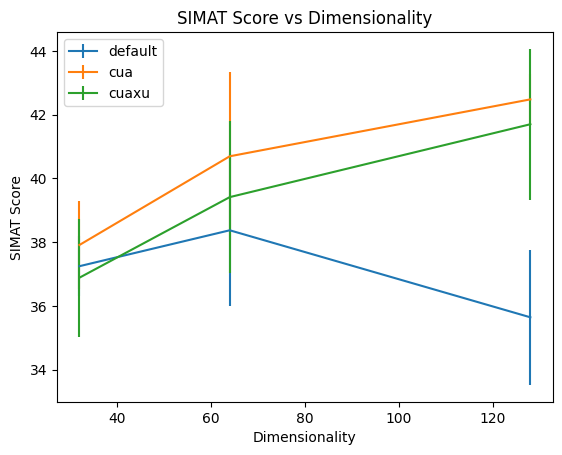

In [28]:
# plot the scores, x axis is dimensionality, y axis is score. Error bars are 1.96 *  standard deviation
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
for loss_name in ['default', 'cua', 'cuaxu']:
    x = list(simat_scores_by_dimensionality_avg.keys())
    y = [simat_scores_by_dimensionality_avg[d][loss_name] for d in x]
    yerr = [1.96 * simat_scores_by_dimensionality_std[d][loss_name] for d in x]
    plt.errorbar(x, y, yerr=yerr, label=loss_name)
plt.xlabel('Dimensionality')
plt.ylabel('SIMAT Score')
plt.title('SIMAT Score vs Dimensionality')



plt.legend()
plt.show()







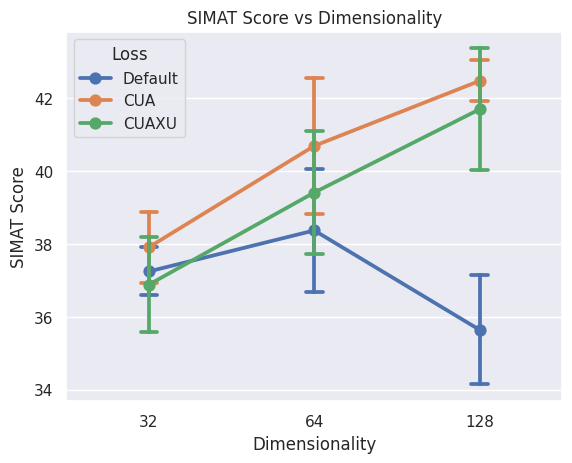

In [57]:
# plot something similar, but using seaborn
import seaborn as sns
import pandas as pd
data = []
# use the raw data to plot
for dimensionality, scores in simat_scores_by_dimensionality.items():
    for loss_name, loss_scores in scores.items():
        for score in loss_scores:
            data.append({'Dimensionality': dimensionality, 'Loss': loss_name.upper() if loss_name != 'default' else 'Default', 'Score': score})



# set sns style to dark grid
sns.set(style='darkgrid')
df = pd.DataFrame(data)
# make error bars as 2 standard deviations

sns.pointplot(data=df, x='Dimensionality', y='Score', hue='Loss', errorbar=('se', 1.96), capsize=.1, palette='deep')

# save the figure
plt.savefig(f'{ROOT}/figures/simat_score_vs_dimensionality.png')

# dont plot for one of the losses
# sns.pointplot(data=df[df['Loss'] != 'cuaxu'], x='Dimensionality', y='Score', hue='Loss', errorbar='ci', capsize=.1, palette='deep')

plt.xlabel('Dimensionality')
plt.ylabel('SIMAT Score')


plt.title('SIMAT Score vs Dimensionality')
plt.show()

# 


### Gap metrics now

In [ ]:
# Read dictionary of gap metrics from the files

import json
ROOT = '/home/afahim2/tmp/clip-project/clipverse'

mod_gap_metrics


